## Model Training
The modeling phase of the machine learning workflow consists in defining the models to be trained, train the created models, and subsequently test each model's accuracy.

I am using Amazon Sagemaker for the training, testing, and deployment of the defined models. 

In [1]:
import os
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow
import statistics
import keras
from statistics import mean, mode, median, stdev
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Activation
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [14]:
# Constants to use for this notebook


time_words = {1:'day', 5:'week', 10:'two_weeks', 20:'month', 90:'four_months', 270:'year'}
time_range = [1, 5, 10, 20, 90, 270]
periods = [5, 10, 20, 90, 270]

# directory containing training and testing datasets
data_dir = join('data_1/') 
final_data_dir = join(data_dir + 'final/')
top_results_file = 'results/top_accuracy.txt'
model_directory = 'models_2/'
history_dir = model_directory

with open(top_results_file) as f:
    text = f.read()
    top_5 = [line for line in text.split('\n')]
    top_5 = [(p.split()[0], p.split()[1]) for p in top_5]
    

In [4]:
# Read training and testing data
data = {}
for mod, _ in top_5:
    data[mod] = {}
    m = mod.split('-')
    train_file = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/train.csv'
    test_file = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/test.csv'

    df_train = pd.read_csv(train_file, header=None)
    df_test = pd.read_csv(test_file, header=None)

    y_train = df_train[0]
    X_train = df_train.drop(labels=0, axis=1)
    y_test = df_test[0]
    X_test = df_test.drop(labels=0, axis=1)

    data[mod]['y_train'] = y_train
    data[mod]['X_train'] = X_train
    data[mod]['y_test'] = y_test
    data[mod]['X_test'] = X_test
    

### Model Definition
Under the ``source/`` directory is the file ``model.py``, which contains the definition for a class named ``BinaryClassifier``. This class defines our base ANN model for this project which hast the following structure:
1. Three parameters need to be passed to the model:
    * ``input_features``: the number of neurons to create for input (11 in this case)
    * ``output_dim``: the number of neurons in the final layer of the ANN. For a binary classifier this is 1, and the result ranges from [0,1].
2. The number of neurons in the 4 hidden layers of the model are defined as:
    * ``2*input_features``
    * ``input_features/2``
3. The forward pass of the model
    * Input layer -> Linear transform to the first hidden layer
    * Passed into Rectifier Linear Unit function
    * Dropout layer (for training only)
    * Repeat the above steps until the final hidden layer...
    * Last hidden layer -> Linear transform to the output layer
    * Sigmoid Activation Function -> Result
    

In [5]:
# Define this model's hidden layer nodes and parameters
input_dim = 11
d1 = 2*input_dim
d2 = round(input_dim/2)
d3 = 1
activation = 'sigmoid'
dropout = 0.4
epochs = 100000
lr = 0.01
batch = 1000

## Plotting live callback definition

In [6]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend(['accuracy', epoch])
        plt.show();
        
plot = PlotLearning()

In [11]:
models = []
for m, _ in top_5:
    input_layer = Input(name='the_input', shape=(input_dim,), batch_shape=(None, input_dim))
    # Add dense layers
    dense_1 = Dense(d1, activation=activation)(input_layer)
    drop_1 = Dropout(dropout)(dense_1)
    dense_2 = Dense(d2, activation=activation)(drop_1)
    drop_2 = Dropout(dropout)(dense_2)
    dense_3 = Dense(d3, activation=activation)(drop_2)

    # Add sigmoid activation layer
    y_pred = Activation('sigmoid', name='sigmoid')(dense_3)
    
    # Specify the model
    model = Model(inputs=input_layer, outputs=y_pred, name=m)
    model.output_length = lambda x: x
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    models.append(model)
    
print(models[0].summary())

Model: "270-90-10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 11)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 22)                264       
_________________________________________________________________
dropout_11 (Dropout)         (None, 22)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 138       
_________________________________________________________________
dropout_12 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 7         
_________________________________________________________________
sigmoid (Activation)         (None, 1)                 0 

### Model Training
The model training will be performed by Amazon Sagemaker. Training jobs will be created for each training dataset in the ``final/`` directory. Under ``source/`` there is a file named ``train.py``, which contains the structure for a PyTorch entry point. This is necesssary for creating estimators through Sagemaker.

In [8]:
histories = []

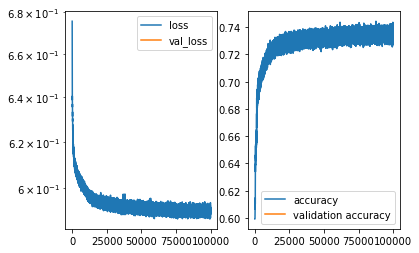

Finished training model: 270-90-10




In [8]:
model = models[0]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)

model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')

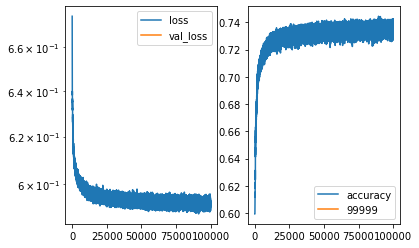

Finished training model: 270-90-270




In [12]:
model = models[1]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)
model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')

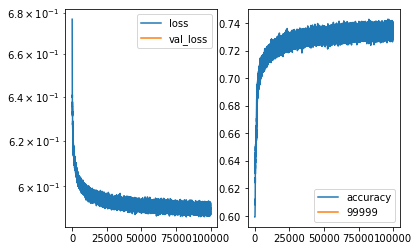

Finished training model: 90-270-10




In [22]:
model = models[2]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)
model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')
allDone()

In [24]:
model = models[3]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)
model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')
allDone()

KeyboardInterrupt: 

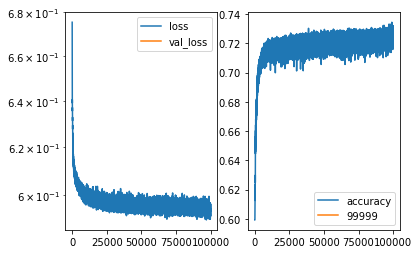

Finished training model: 20-10-270




In [25]:
model = models[4]
name = model.name
history = model.fit(x=X_train, 
          y=y_train,
          batch_size=batch,
          epochs=epochs,
          verbose=0,
          callbacks=[plot]
         )
histories.append(history)
model.save(model_directory+name+'.h5')
df = pd.DataFrame.from_dict(history.history)
df.to_csv(model_directory+name+'_history.csv')
print('Finished training model: '+name+'\n\n')
allDone()

In [ ]:
# for model in models:
#     name = model.name
#     history = model.fit(x=X_train, 
#               y=y_train,
#               batch_size=batch,
    #               epochs=epochs,
    #               verbose=0,
#               callbacks=[plot]
#              )
#     histories.append(history)
#     model.save(model_directory+name+'.h5')
#     print('Finished training model: '+name+'\n\n')

### Model Evaluation
For evaluation I am deploying each training job created. For each estimator, a predictor endpoint is created briefly to be sent data to make predictions. For each predictor, their respective test datasets are passed. The endpoint for the predictor is then deleted. Then, accuracy calculations are made against the labeled test datasets, they are printed and stored into ``.txt`` files under the ``results/`` directory.


In [7]:
models = []
for m, _ in top_5:
    models.append(keras.models.load_model(model_directory+m+'.h5'))

In [8]:
# Read training and testing data separated by tickers
data = {}
for mod, _ in top_5:
    data[mod] = {}
    data[mod]['train'] = {}
    data[mod]['test'] = {}
    m = mod.split('-')
    directory_tr = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/train/'
    directory_ts = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/test/'
    
    for filename in os.listdir(directory_tr):
        df = pd.read_csv(directory_tr+filename, header=None).iloc[::-1]
        data[mod]['train'][filename.split('.')[0]+'_y'] = df[0]
        data[mod]['train'][filename.split('.')[0]+'_X'] = df.drop(labels=0, axis=1)
    for filename in os.listdir(directory_ts):
        df = pd.read_csv(directory_ts+filename, header=None).iloc[::-1]
        data[mod]['test'][filename.split('.')[0]+'_y'] = df[0]
        data[mod]['test'][filename.split('.')[0]+'_X'] = df.drop(labels=0, axis=1)


    
    

In [9]:
tickers_file = 'ndxt_tickers.txt'
ndxt_tickers = []
with open('data/'+tickers_file) as f:
    for ticker in f:
        ndxt_tickers.append(ticker.replace('\n', ''))

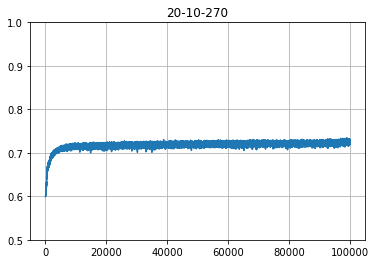

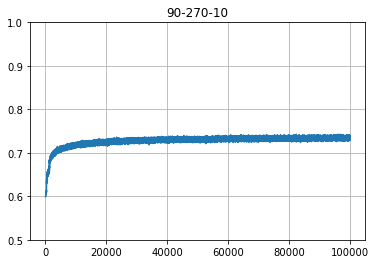

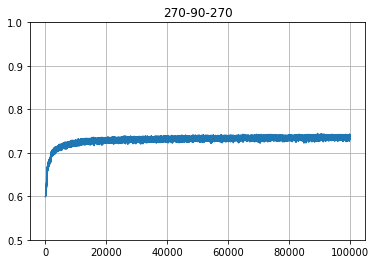

In [21]:
for t in time_range:
    
    
    for i, n1 in enumerate(periods):
        for j, n2 in enumerate(periods):
            
            name = f'{t}-{n1}-{n2}'
            
            filepath = history_dir + name + '_history.csv'
            
            try:
                df = pd.read_csv(filepath)
            except:
                continue
            
            idx = i + 5*j + 1
            
            plt.subplot()


            plt.plot(df['accuracy'])
            plt.title(name)
            plt.ylim((0.5,1))
            
            plt.grid(True)
            
            plt.show()

In [10]:
evaluation = {}
for model in models:
    evaluation[model.name] = {}
    
    for symbol in ndxt_tickers:
        evaluation[model.name][symbol] = []
        length = len(data[model.name]['test'][symbol+'_X'])
        data_X = data[model.name]['test'][symbol+'_X']
        data_y = data[model.name]['test'][symbol+'_y']
        
        for i in range(length):
            x = data_X[i:i+1]
            y = data_y[i:i+1]
            evaluation[model.name][symbol].append(model.evaluate(x, y, verbose=0)[1])

In [24]:
# Calculate average accuracies for each symbol in evaluations of every model
acc_streaks = {}
for mod, evals in evaluation.items():
    acc_streaks[mod] = {}
    acc_streaks[mod]['accuracy'] = []
    acc_streaks[mod]['streak'] = []
    
    
    for symbol, accuracies in evals.items():
        acc = round(sum(accuracies)/len(accuracies),2)
        
        streak = 0
        for i, a in enumerate(accuracies):
            if a != 1: 
                streak = i
                break
        
        acc_streaks[mod]['accuracy'].append(acc)
        acc_streaks[mod]['streak'].append(streak)
        
        

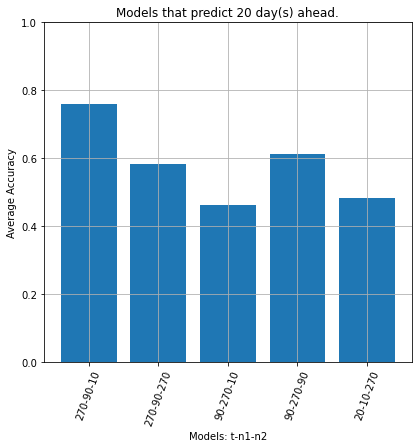

In [29]:
plot_1 = {mod:vals for mod, vals in acc_streaks.items() if mod.split('-')[0] == '1'}
plot_5 = {mod:vals for mod, vals in acc_streaks.items() if mod.split('-')[0] == '5'}
plot_10 = {mod:vals for mod, vals in acc_streaks.items() if mod.split('-')[0] == '10'}
plot_20 = {mod:vals for mod, vals in acc_streaks.items() if mod.split('-')[0] == '20'}
plot_90 = {mod:vals for mod, vals in acc_streaks.items() if mod.split('-')[0] == '90'}
plot_270 = {mod:vals for mod, vals in acc_streaks.items() if mod.split('-')[0] == '270'}

to_plot = [plot_1, 
           plot_5, 
           plot_10, 
           plot_20, 
           plot_90, 
           plot_270]

plt.figure(figsize=(18,12))
ylim = max([item for sublist in [v['accuracy'] for mod, v in acc_streaks.items()] for item in sublist])

accuracies = []
streaks = []
plt.subplot(2, 3, i+1)
plt.grid()

for mod, vals in acc_streaks.items():
    avg_acc = sum(vals['accuracy'])/len(vals['accuracy'])
    avg_streak = sum(vals['streak'])/len(vals['streak'])
    accuracies.append(avg_acc)
    streaks.append(avg_streak)

days = mod.split('-')[0]
mods = list(acc_streaks.keys())
plt.bar(x= range(len(mods)), height= accuracies)
plt.xticks(ticks= range(len(mods)), labels=mods, rotation=70)
plt.ylim((0,ylim))
plt.xlabel('Models: t-n1-n2')
plt.ylabel('Average Accuracy')
plt.title(f'Models that predict {days} day(s) ahead.')

plt.tight_layout(pad=3.0)

plt.show()

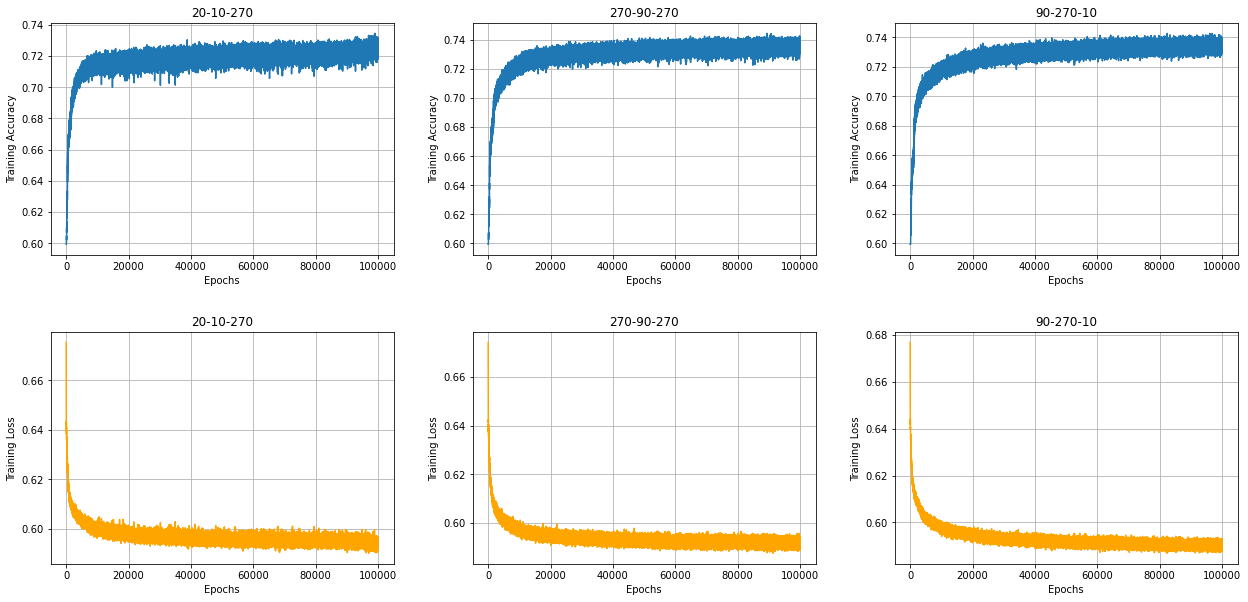

In [49]:
plt.figure(figsize=(18, 9))
i=0
for f in os.listdir(model_directory):
    if '.csv' in f:
        i += 1
        name = f.split('.csv')[0]
        
        plt.subplot(2,3, i)
        plt.grid()
        
        df = pd.read_csv(model_directory+f, index_col=0)
        
        plt.title(name.split('_')[0])
        plt.xlabel('Epochs')
        plt.ylabel('Training Accuracy')
        
        plt.plot(df['accuracy'])
        
        plt.subplot(2,3, i+3)
        plt.grid()
        
        df = pd.read_csv(model_directory+f, index_col=0)
        
        plt.title(name.split('_')[0])
        plt.xlabel('Epochs')
        plt.ylabel('Training Loss')
        
        plt.plot(df['loss'], color='orange')
        
plt.tight_layout(pad=3.0)
plt.show()